In [10]:
import mlflow
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from constants import (CATEGORICAL_FEATURES, LABEL, MLFLOW_URI,
                       NUMERICAL_FEATURES, RANDOM_STATE)
from utils import download_data, save_to_mlflow

In [2]:
mlflow.set_tracking_uri(MLFLOW_URI)

In [3]:
download_data()

Kaggle credentials set.


In [4]:
df = pd.read_csv("data/1/heart_failure_clinical_records_dataset.csv")
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [5]:
features = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

X = df[features]
y = df[LABEL]

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

## Model Selection

- Escolha da metrica: é mais grave dizer que uma pessoa não é doente quando ela de fato é, que dizer que ela é doente e ela não ser
- Recall e Confusion Matrix
- Cuidado para aplicar mesmo pipeline
- Distribuicao parecida do y_train e do y_test

## Random Forest

In [21]:
experiment_name = "Random Forest"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1732585950824, experiment_id='1', last_update_time=1732585950824, lifecycle_stage='active', name='Random Forest', tags={}>

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50;, score=0.709 total time=   0.2s
[CV 2/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50;, score=0.822 total time=   0.2s
[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=50;, score=0.744 total time=   0.2s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100;, score=0.790 total time=   0.3s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=50;, score=0.796 total time=   0.2s
[CV 2/3] END model__class_weig

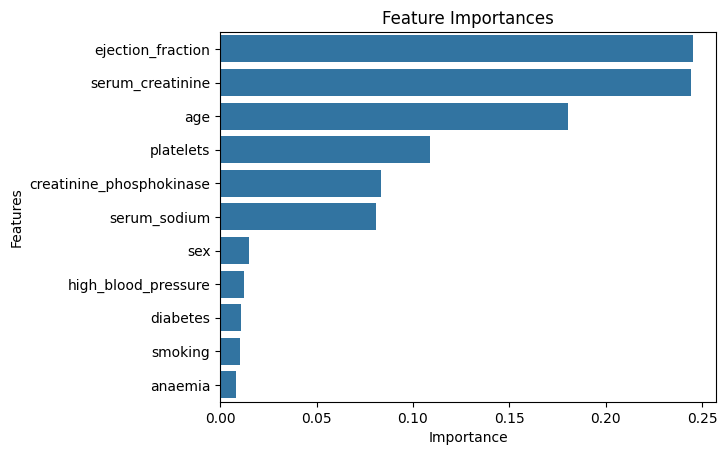

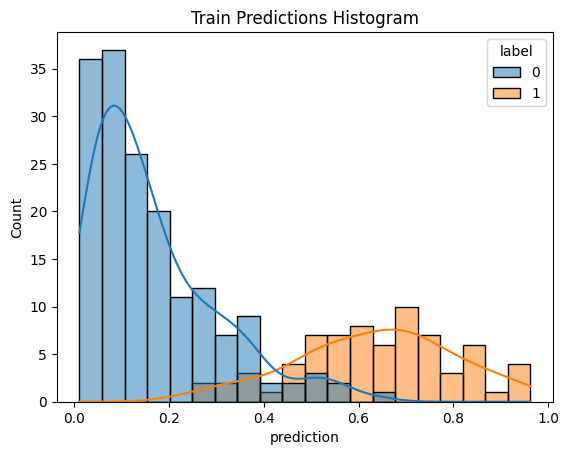

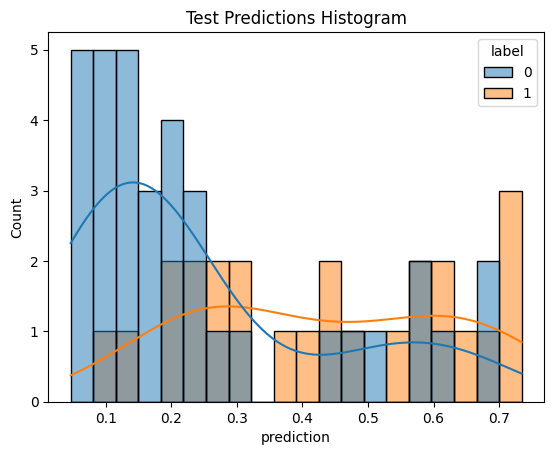

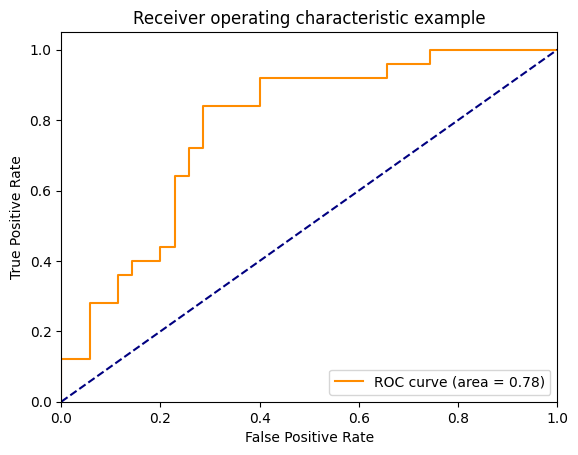

2024/11/25 22:57:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run first HPT GridSearch at: http://localhost:5000/#/experiments/1/runs/e020851a88034e88a422d99443c38fee.
2024/11/25 22:57:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


In [7]:
run_name = "first HPT GridSearch"

pipeline = Pipeline([('model', RandomForestClassifier(random_state=RANDOM_STATE))])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)
with mlflow.start_run(run_name=run_name) as run:
    grid_search.fit(X_train, y_train)
    save_to_mlflow(
        pipeline=grid_search.best_estimator_,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test, 
        run=run,
        experiment_metadata=param_grid,
    )

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 2/3] END model__class_weight={0: 1, 1: 1}, model__criterion=gini, model__max_depth=None, model__n_estimators=10;, score=0.773 total time=   0.0s[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__criterion=gini, model__max_depth=None, model__n_estimators=10;, score=0.725 total time=   0.0s

[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__criterion=gini, model__max_depth=None, model__n_estimators=10;, score=0.790 total time=   0.0s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__criterion=gini, model__max_depth=5, model__n_estimators=10;, score=0.766 total time=   0.0s
[CV 2/3] END model__class_weight={0: 1, 1: 1}, model__criterion=gini, model__max_depth=5, model__n_estimators=10;, score=0.798 total time=   0.0s
[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__criterion=gini, model__max_depth=5, model__n_estimators=10;, score=0.712 total time=   0.0s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model

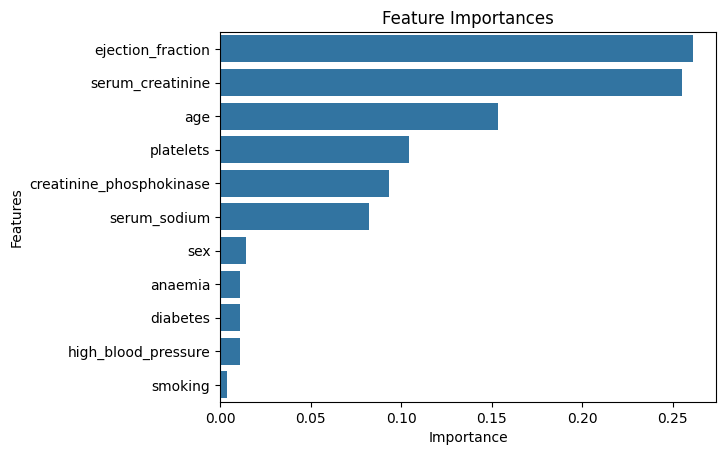

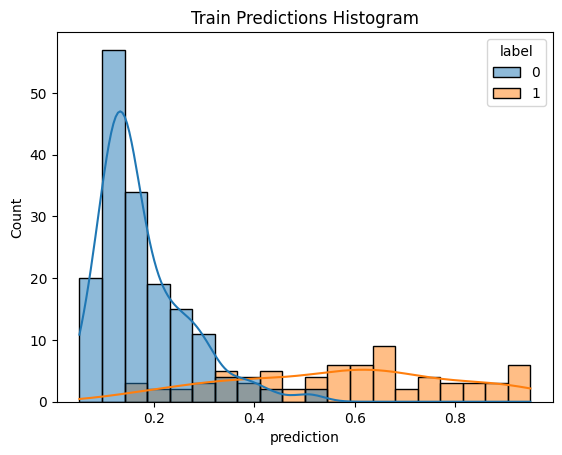

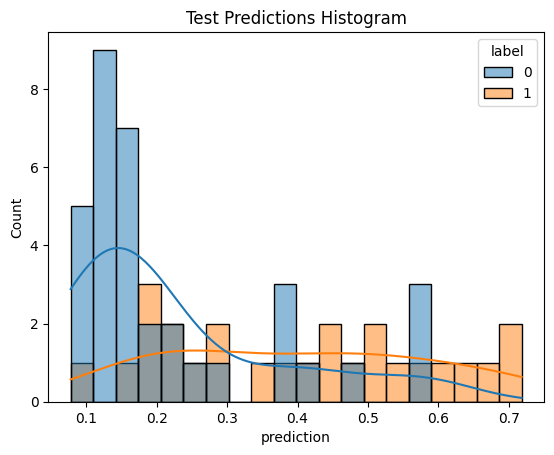

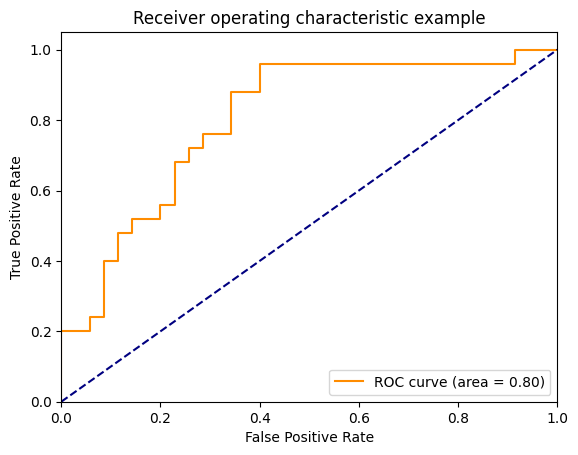

2024/11/26 00:12:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run fourth HPT GridSearch with criterion at: http://localhost:5000/#/experiments/1/runs/879cc1b525334ac3a4a12b3d91ccfced.
2024/11/26 00:12:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


In [24]:
run_name = "fourth HPT GridSearch with criterion"

pipeline = Pipeline([('model', RandomForestClassifier(random_state=RANDOM_STATE))])

param_grid = {
    'model__n_estimators': [10, 20, 30],
    'model__max_depth': [None, 5, 7, 10],
    "model__criterion": ["gini", "entropy", "log_loss"],
    'model__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)
with mlflow.start_run(run_name=run_name) as run:
    grid_search.fit(X_train, y_train)
    save_to_mlflow(
        pipeline=grid_search.best_estimator_,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test, 
        run=run,
        experiment_metadata=param_grid,
    )

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__n_estimators=10;, score=0.659 total time=   0.0s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__n_estimators=10;, score=0.770 total time=   0.0s
[CV 2/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__n_estimators=10;, score=0.678 total time=   0.0s
[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=5, model__n_estimators=10;, score=0.705 total time=   0.0s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=5, model__n_estimators=10;, score=0.714 total time=   0.0s
[CV 2/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=5, model__n_estimators=10;, score=0.701 total time=   0.0s
[CV 3/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=None, model__n_estimators=20;, score=0.674 total time=   0.0s
[CV 1/3] END model__class_weight={0: 1, 1: 1}, model__max_depth=No

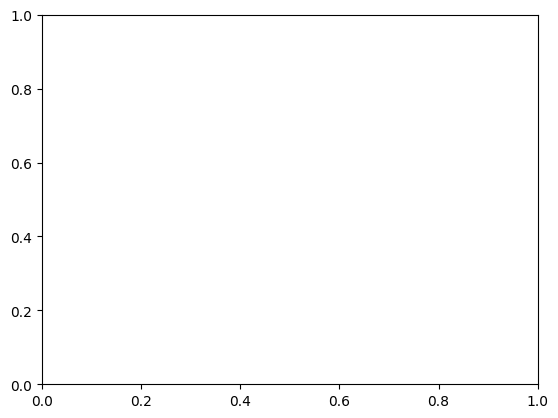

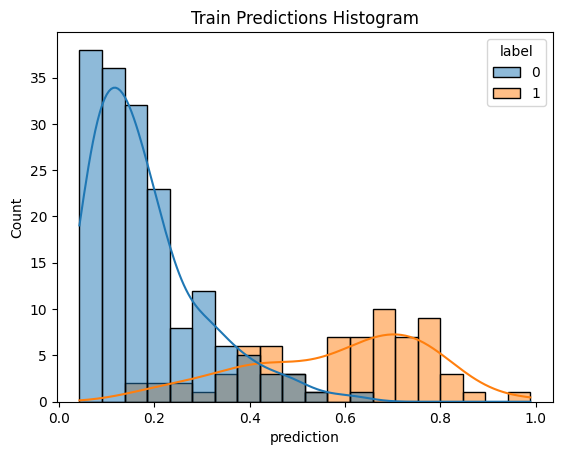

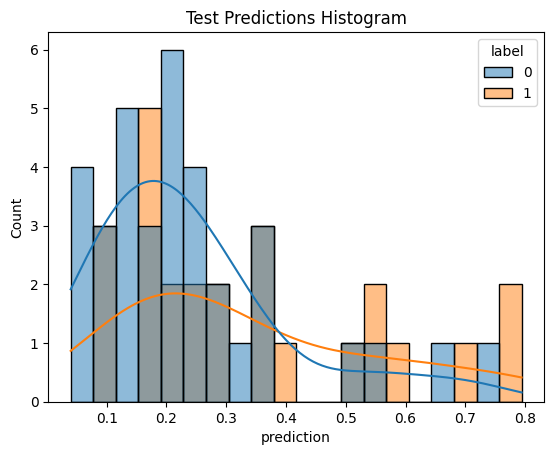

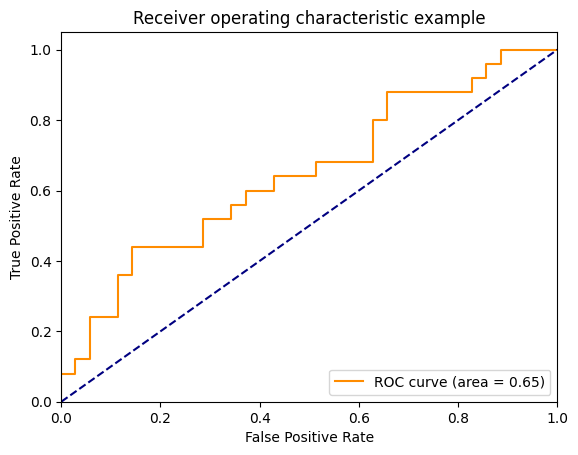

2024/11/26 00:15:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run HPT GridSearch W PCA AND SCALER at: http://localhost:5000/#/experiments/1/runs/2265c7a7ccaa42cab9a3224bf70b82ca.
2024/11/26 00:15:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/1.


In [26]:


run_name = "HPT GridSearch W PCA AND SCALER"

pipeline = Pipeline([("scaler", StandardScaler()),("pca", PCA()), ('model', RandomForestClassifier(random_state=RANDOM_STATE))])

param_grid = {
    'model__n_estimators': [10, 20],
    'model__max_depth': [None, 5, 7, 10],
    'model__class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)
with mlflow.start_run(run_name=run_name) as run:
    grid_search.fit(X_train, y_train)
    save_to_mlflow(
        pipeline=grid_search.best_estimator_,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test, 
        run=run,
        experiment_metadata=param_grid,
    )

## Logistic Regression

In [16]:
experiment_name = "Logistic Regression"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1732586417406, experiment_id='2', last_update_time=1732586417406, lifecycle_stage='active', name='Logistic Regression', tags={}>

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .....................model__C=0.01;, score=0.856 total time=   0.0s
[CV 2/3] END ....................model__C=0.001;, score=0.760 total time=   0.0s
[CV 1/3] END ....................model__C=0.001;, score=0.835 total time=   0.0s
[CV 2/3] END ......................model__C=0.1;, score=0.801 total time=   0.0s
[CV 3/3] END ....................model__C=0.001;, score=0.590 total time=   0.0s
[CV 2/3] END .....................model__C=0.01;, score=0.792 total time=   0.0s
[CV 3/3] END .....................model__C=0.01;, score=0.610 total time=   0.0s
[CV 3/3] END ......................model__C=0.1;, score=0.684 total time=   0.1s
[CV 2/3] END ........................model__C=1;, score=0.778 total time=   0.0s
[CV 1/3] END ......................model__C=0.1;, score=0.853 total time=   0.0s
[CV 1/3] END ........................model__C=1;, score=0.849 total time=   0.1s
[CV 3/3] END ........................model__C=1;,

/home/samcbk/.virtualenvs/ita/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/samcbk/.virtualenvs/ita/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

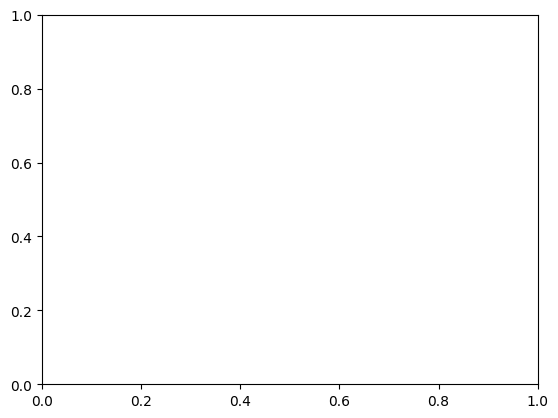

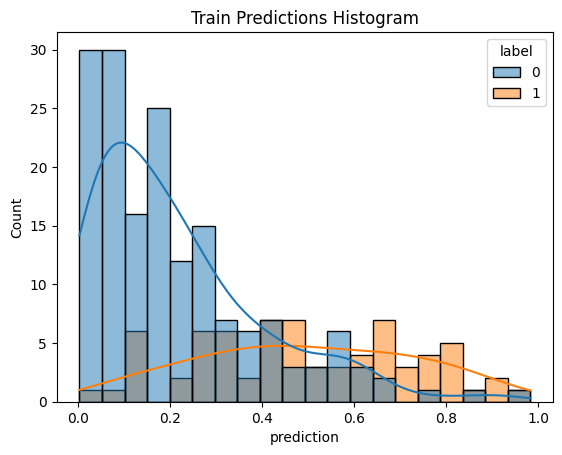

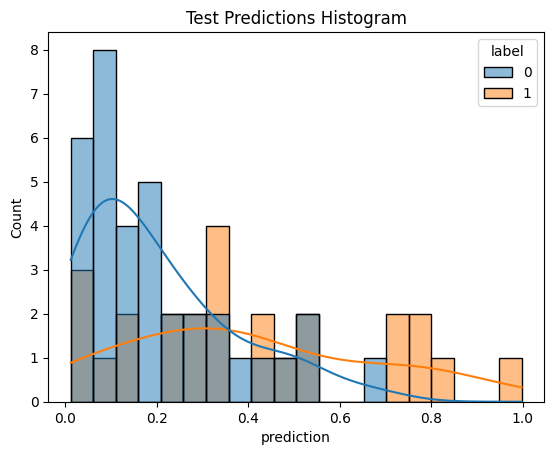

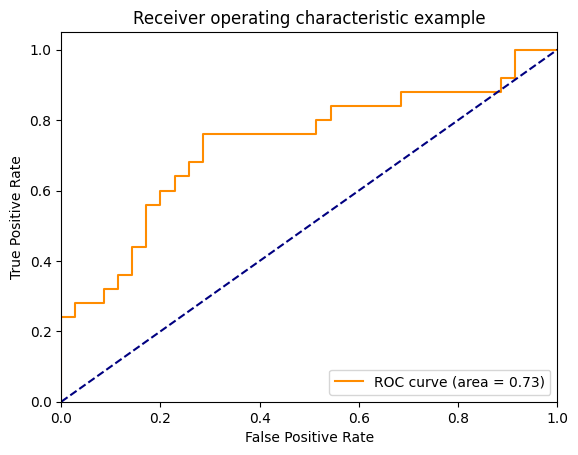

2024/11/26 00:07:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression 1000 it at: http://localhost:5000/#/experiments/2/runs/aabe6c187e34496f8c063bdcca3ffff7.
2024/11/26 00:07:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


In [17]:
from sklearn.linear_model import LogisticRegression


run_name = "Logistic Regression 1000 it"

pipeline = Pipeline([('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

param_grid = {
    'model__C': [1, 0.1, 0.01, 0.001],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)
with mlflow.start_run(run_name=run_name) as run:
    grid_search.fit(X_train, y_train)
    save_to_mlflow(
        pipeline=grid_search.best_estimator_,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test, 
        run=run,
        experiment_metadata=param_grid,
    )

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 3/3] END ...................model__C=0.0001;, score=0.681 total time=   0.0s
[CV 2/3] END .....model__C=0.046415888336127774;, score=0.722 total time=   0.0s
[CV 1/3] END ...................model__C=0.0001;, score=0.808 total time=   0.0s
[CV 2/3] END ...................model__C=0.0001;, score=0.723 total time=   0.0s
[CV 1/3] END .....model__C=0.046415888336127774;, score=0.808 total time=   0.0s
[CV 3/3] END .....model__C=0.046415888336127774;, score=0.681 total time=   0.0s
[CV 1/3] END ........model__C=21.54434690031882;, score=0.808 total time=   0.0s
[CV 2/3] END ........model__C=21.54434690031882;, score=0.722 total time=   0.0s
[CV 3/3] END ........model__C=21.54434690031882;, score=0.681 total time=   0.0s
[CV 2/3] END ..................model__C=10000.0;, score=0.722 total time=   0.0s
[CV 1/3] END ..................model__C=10000.0;, score=0.808 total time=   0.0s
[CV 3/3] END ..................model__C=10000.0;,

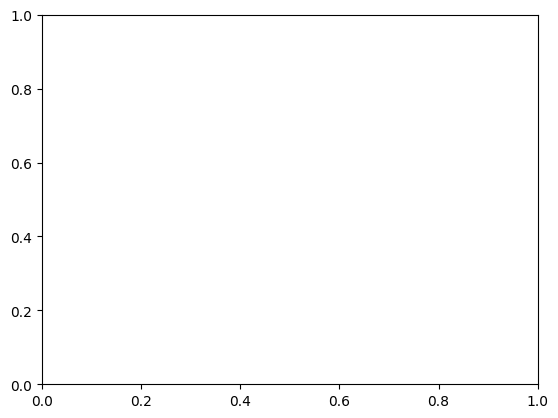

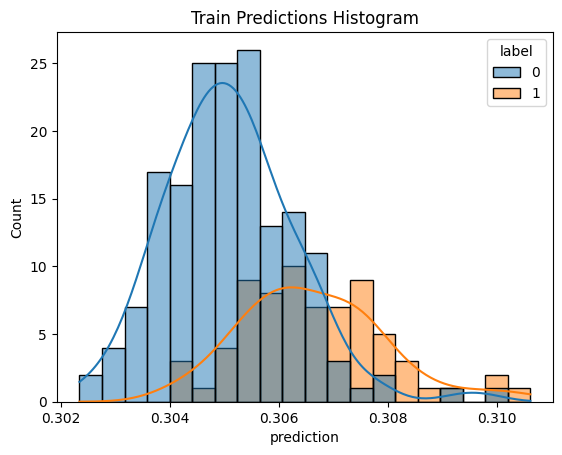

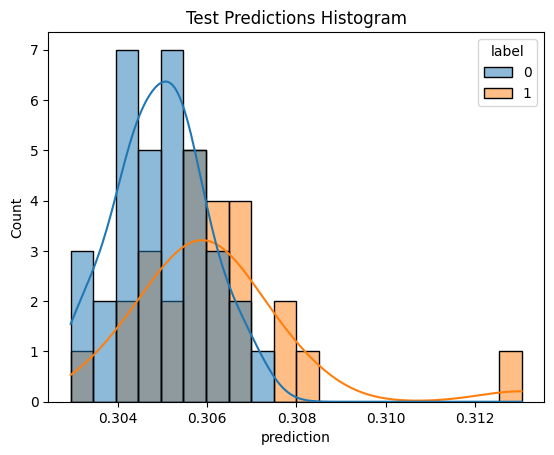

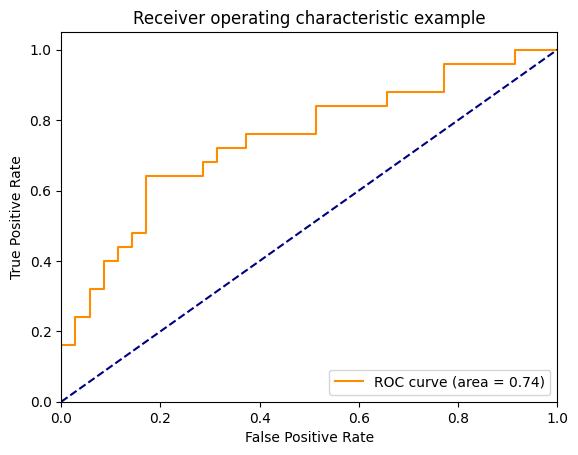

2024/11/26 00:09:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression W Scaler and log grid space and 10k it at: http://localhost:5000/#/experiments/2/runs/7f30ffdb35584ca48e068e2354d0bbf0.
2024/11/26 00:09:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/2.


In [20]:
from sklearn.linear_model import LogisticRegression


run_name = "Logistic Regression W Scaler and log grid space and 10k it"

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(max_iter=10000, random_state=RANDOM_STATE, tol=0.1),
        ),
    ]
)

param_grid = {
    # "pca__n_components": [5, 15, 30, 45, 60],
    "model__C": np.logspace(-4, 4, 4),
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=3, scoring="roc_auc", n_jobs=-1, verbose=3
)
with mlflow.start_run(run_name=run_name) as run:
    grid_search.fit(X_train, y_train)
    save_to_mlflow(
        pipeline=grid_search.best_estimator_,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        run=run,
        experiment_metadata=param_grid,
    )

## LightGBM

In [16]:
import lightgbm as lgb

In [17]:
experiment_name = "LGBM"
mlflow.set_experiment(experiment_name)

2024/11/25 23:07:30 INFO mlflow.tracking.fluent: Experiment with name 'LGBM' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1732586850229, experiment_id='3', last_update_time=1732586850229, lifecycle_stage='active', name='LGBM', tags={}>

[LightGBM] [Info] Number of positive: 71, number of negative: 168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 239, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.297071 -> initscore=-0.861284
[LightGBM] [Info] Start training from score -0.861284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


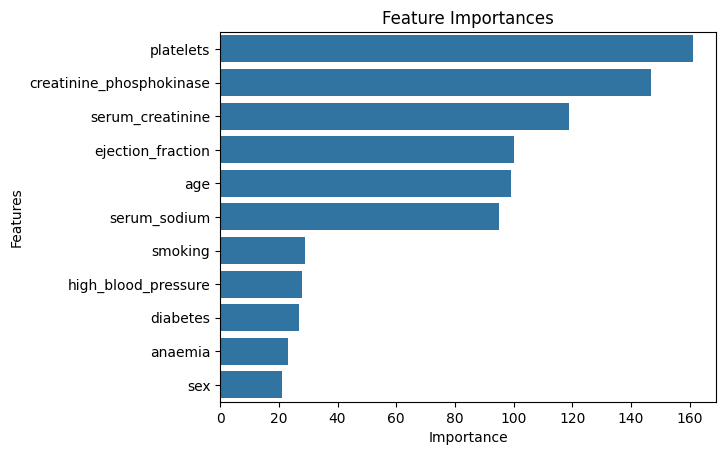

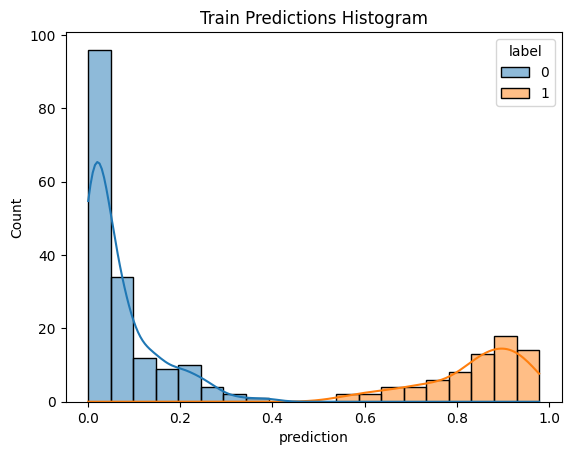

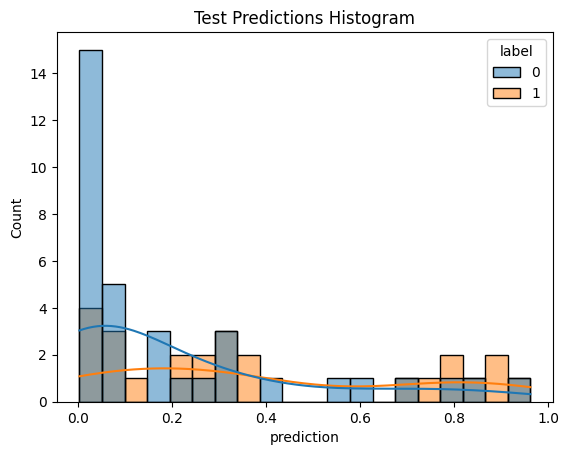

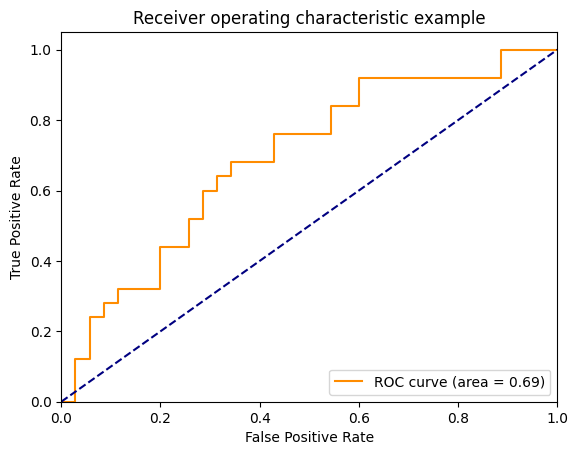

2024/11/25 23:26:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-deer-651 at: http://localhost:5000/#/experiments/3/runs/64e779fb0163458ea7982ba17ce2a949.
2024/11/25 23:26:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


In [ ]:
run_name = "LGBM Run 1"
run_name = None

pipeline = Pipeline(
    [
        (
            "model",
            lgb.LGBMClassifier(
                random_state=RANDOM_STATE,
                boosting_type="gbdt",
                objective="binary",
                metric="binary_logloss",
            ),
        )
    ]
)

param_grid = {
    "model__learning_rate": 0.01,
    "model__max_depth": 2,
    "model__n_estimators": 2,
}

# grid_search = GridSearchCV(
#     pipeline, param_grid, cv=3, scoring="roc_auc", n_jobs=-1, verbose=3
# )
with mlflow.start_run(run_name=run_name) as run:
    pipeline.fit(X_train, y_train)
    save_to_mlflow(
        pipeline=pipeline,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        run=run,
        experiment_metadata=param_grid,
    )